MultiRAT analysis code
================
Joanes Grandjean

![rat art](../assets/img/rat_art.png)

# Foreword

This is a jupyter notebook which contains all the code for reproducing my
analysis. The code is meant to be followed step-wise. 

If re-using some of the scripts, please follow citations guidelines for
the software used. I’ve provided the links to the software wherever
possible. See also the [license](../LICENSE.md) for this software.

From the preregistration: 
"If sufficient dataset (n=4 dataset per stimulated area) is collected, we will examine the spatial specificity and response amplitude distribution of stimulus-evoked fMRI experiments. Briefly, beta parameter estimates for the stimulation will be obtained using a GLM approach (fsl_glm). One-sample t-test group spatial maps (Randomize, TFCE correction, p-value threshold = 0.05) will be compared for spatial delineation. Beta parameter estimate within both the ipsi- and contralateral cortical region being stimulated will be extracted (fslmeants) and plotted per dataset. The time-locked BOLD course will be extracted from the same ROI and plotted as the average per dataset. The residual following the GLM analysis will be plotted to inspect if  standard human-derived haemodynamic parameters are sufficient to model rat haemodynamic response.  "


In [1]:
# init variables
init_folder='/home/traaffneu/joagra/code/MultiRat'
analysis_folder='/project/4180000.19/multiRat'
df_path='../assets/table/meta_data_20210622.tsv'

In [34]:
import os
import glob
import pandas as pd
import numpy as np

template=os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Template_Masked.nii')
mask=os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Mask.nii') 

atlas=os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Brain_Atlases',
                      'SIGMA_Anatomical_Atlas',
                      'SIGMA_Anatomical_Brain_Atlas.nii')
atlas_roi=pd.read_csv(os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Brain_Atlases',
                      'SIGMA_Anatomical_Atlas',
                      'SIGMA_Anatomical_Brain_Atlas_Labels.txt'), 
                      skiprows=15, 
                      sep='\t',
                      header=None,
                      usecols=[0,7], 
                      names=['Roi_ID', 'Roi_name']).sort_values(by=['Roi_ID'],ignore_index=True)

df = pd.read_csv(df_path, sep='\t')

In [207]:
#output folders
os.makedirs(os.path.join(analysis_folder,'scratch', 'stim_sub_img'), exist_ok=True)
os.makedirs(os.path.join(analysis_folder,'scratch', 'stim_sub_ts'), exist_ok=True)
os.makedirs(os.path.join(analysis_folder,'scratch', 'stim_sub_plot'), exist_ok=True)

In [183]:
df_exclude = df.loc[(df['exclude'] != 'yes')].loc[(df['exp.type'] == 'stimulus-evoked')].loc[(df['rat.ds'].isin([2001,2002,2003]))]

In [4]:
stim_list = glob.glob((os.path.join(analysis_folder, 'scratch', 'stim'))+'/*')

/home/traaffneu/joagra/.conda/envs/multirat/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:73: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn("'trial_type' column not found "
/home/traaffneu/joagra/.conda/envs/multirat/lib/python3.9/site-packages/nilearn/glm/regression.py:359: FutureWarning: 'resid' from RegressionResults has been deprecated and will be removed. Please use 'residuals' instead.
  warnings.warn("'resid' from RegressionResults "
/home/traaffneu/joagra/.conda/envs/multirat/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:73: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn("'trial_type' column not found "
/home/traaffneu/joagra/.conda/envs/multirat/lib/python3.9/site-packages/nilearn/glm/regression.py:359: FutureWarning: 'resid' from RegressionResults has been deprecated and will be removed. Please use 'residuals' instead.
  warnings.warn("'re

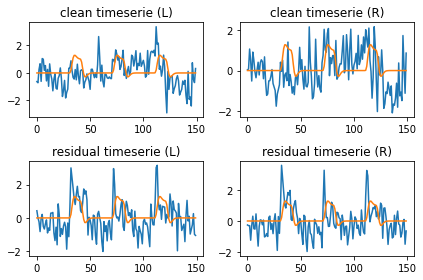

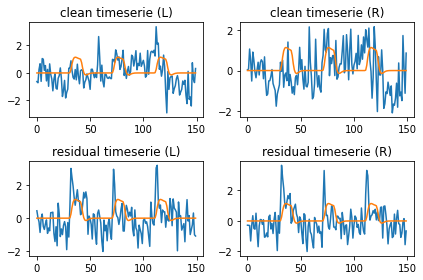

In [209]:
from nilearn import plotting
from nilearn.input_data import NiftiMasker
from nilearn.glm.first_level import make_first_level_design_matrix,FirstLevelModel
#from nilearn.plotting import plot_design_matrix #vesigial
import numpy as np
import matplotlib.pyplot as plt


motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
hrf_list = ['glover', 'spm']
masker = NiftiLabelsMasker(labels_img=atlas, standardize=True)

for i in list(range(0,1)): #list(range(0,df.shape[0])):
    for hrf_model in hrf_list:


        ft = frame_times = np.arange(df_exclude['func.volume'].iloc[i]) * df_exclude['func.TR'].iloc[i]
        onset = df_exclude['func.sensory.onset'].iloc[i]
        duration = df_exclude['func.sensory.duration'].iloc[i]

        events = pd.DataFrame()
        events['onset'] = list(map(float, onset.split(',')))
        events['duration'] = list(map(float, duration.split(',')))



        motion_file = 'sub-0'+str(df_exclude['rat.sub'].iloc[i])+'_ses-'+str(df_exclude['rat.ses'].iloc[i])+'*.csv'
        motion_path = glob.glob(os.path.join(analysis_folder, 'scratch', 'motion','confound',motion_file))

        motion = pd.read_csv(motion_path[0],sep=',')[motion_names]


        design_matrices = make_first_level_design_matrix(ft, 
                                                 events, 
                                                 drift_model='polynomial', 
                                                 drift_order=3,
                                                 add_regs=motion, 
                                                 add_reg_names=motion_names,
                                                 hrf_model=hrf_model,
                                                  high_pass=0.01)

#plot_design_matrix(design_matrices)                               

        subject_file = 'sub-0'+str(df_exclude['rat.sub'].iloc[i])+'_ses-'+str(df_exclude['rat.ses'].iloc[i])+'*.nii.gz'
        subject_data = glob.glob(os.path.join(analysis_folder, 'scratch', 'stim',subject_file))[0]


        fmri_glm = FirstLevelModel(signal_scaling=False, min_onset=5, mask_img=mask, minimize_memory=False)
        fmri_glm = fmri_glm.fit(subject_data, design_matrices=design_matrices)

        contrast_matrix = np.eye(design_matrices.shape[1])
        contrast_matrix[0]
        z_map = fmri_glm.compute_contrast(contrast_matrix[0], output_type='z_score')
        
        filename_export = 'sub-0'+str(df_exclude['rat.sub'].iloc[i])+"_"+hrf_model
        filename_path=os.path.join(analysis_folder,'scratch', 'stim_sub_img',filename_export)
        plotting.plot_stat_map(
                z_map, bg_img=template, threshold=1.92,
                title=filename_export,                      
                symmetric_cbar=True,
                cmap='coolwarm',
                black_bg=False,
                cut_coords=(0,0.14,5),
                output_file=filename_path+'.png')
        
        roiL=atlas_roi[atlas_roi['Roi_name']=="Primary Somatosensory Cortex Forelimb-L"].index                      
        roiR=atlas_roi[atlas_roi['Roi_name']=="Primary Somatosensory Cortex Forelimb-R"].index  

        confounds= design_matrices.drop(columns=design_matrices.columns[0])
        timeseries = masker.fit_transform(subject_data, confounds=confounds)
        residual_timeseries = masker.fit_transform(fmri_glm.residuals[0])

        
        fig, axs = plt.subplots(2, 2)

        ts_merge=np.vstack((np.array(design_matrices['dummy']), 
                                np.array(np.squeeze(denoise_timeseries[:,roiL])),
                                np.array(np.squeeze(denoise_timeseries[:,roiR])),
                                np.array(np.squeeze(residual_timeseries[:,roiL])),
                                np.array(np.squeeze(residual_timeseries[:,roiR])))).transpose()

        ts_merge = pd.DataFrame(ts_merge)
        ts_merge.columns=['model', 'Timeserie_L','Timeserie_R','Residual_L','Residual_R']
        
        filename_path=os.path.join(analysis_folder,'scratch', 'stim_sub_ts',filename_export)
        ts_merge.to_csv(filename_path+'.csv', index=False)
        
        axs[0, 0].plot(ts_merge[['Timeserie_L','model']])
        axs[0, 0].set_title('clean timeserie (L)')

        axs[0, 1].plot(ts_merge[['Timeserie_R','model']])
        axs[0, 1].set_title('clean timeserie (R)')

        axs[1, 0].plot(ts_merge[['Residual_L','model']])
        axs[1, 0].set_title('residual timeserie (L)')

        axs[1, 1].plot(ts_merge[['Residual_R','model']])
        axs[1, 1].set_title('residual timeserie (R)')

        filename_path=os.path.join(analysis_folder,'scratch', 'stim_sub_plot',filename_export)
        
        plt.tight_layout()
        plt.savefig(filename_path+'.png')